# Image Classifier using MobileNetV2 Transfer Learning


### 1. Import Libraries

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50  # Or another model you choose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


### 2. Mount Drive & Define Paths

#### If we use Google Colab the path should be in this manner  




from google.colab import drive  
drive.mount('/content/drive')

In [6]:
dataset_path = 'Animals'
print(os.listdir(dataset_path))

['cats', 'dogs', 'snakes']


### 3. Preprocessing & Data Augmentation

In [7]:
img_height, img_width = 224, 224  # Standard for transfer learning
batch_size = 32  # batch_size means number of images processed together 

datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values to [0, 1]
    validation_split=0.2   # 80% training, 20% validation
)


In [8]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


### 4. Data Visualization & Exploration

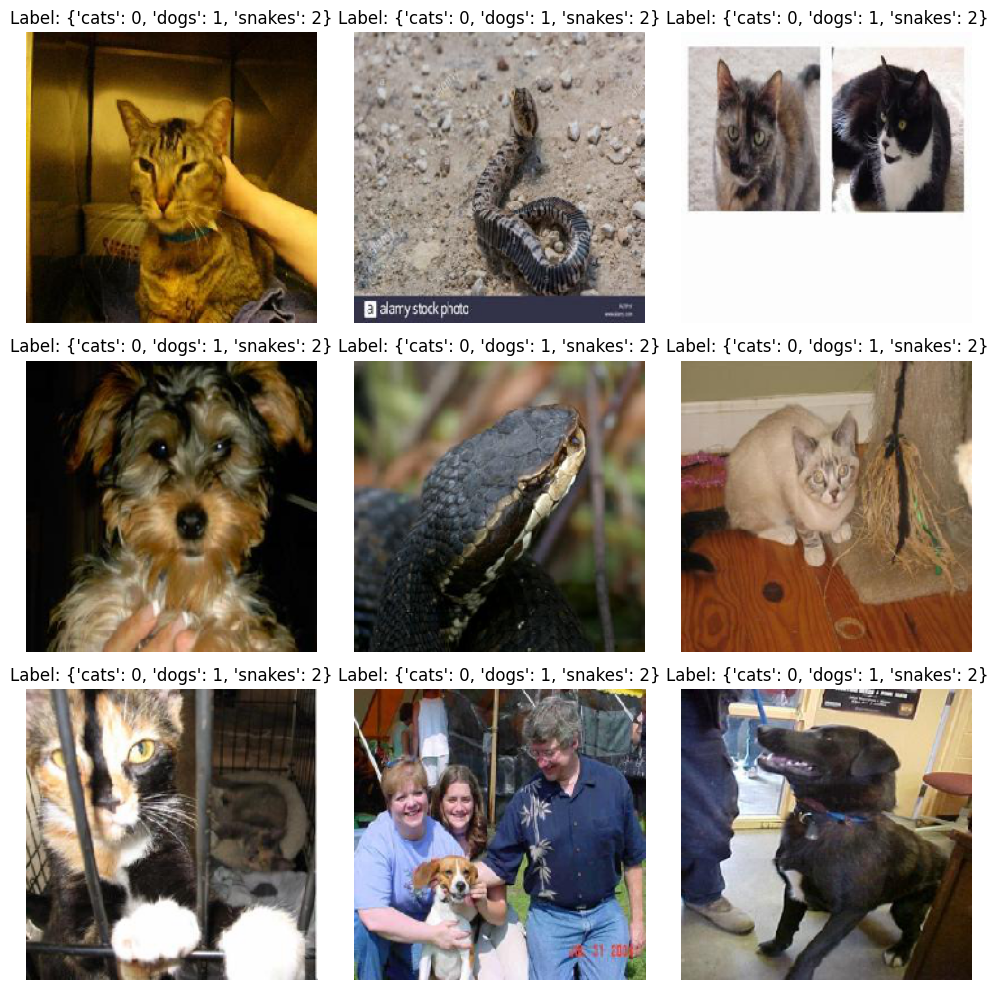

In [9]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Show first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {train_generator.class_indices}")
    plt.axis("off")
plt.tight_layout()
plt.show()


### 5. Load Base Model (MobileNetV2) for Transfer Learning

In [10]:
# Load MobileNetV2 without the top layer (no classifier), with ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers so they are not trained initially
base_model.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)    # Flatten feature maps to vector
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)                # Reduce overfitting
predictions = Dense(3, activation='softmax')(x)  # 3 classes

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 6. Build and Train the Model

In [11]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # means stop training if validation loss does not improve for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7) # Reduce learning rate if validation loss does not improve for 2 epochs

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

c:\Users\hrana\anaconda3\envs\ml_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 731ms/step - accuracy: 0.5681 - loss: 0.9509 - val_accuracy: 0.9683 - val_loss: 0.1725 - learning_rate: 1.0000e-04
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 403ms/step - accuracy: 0.9454 - loss: 0.2050 - val_accuracy: 0.9750 - val_loss: 0.0918 - learning_rate: 1.0000e-04
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 403ms/step - accuracy: 0.9679 - loss: 0.1174 - val_accuracy: 0.9783 - val_loss: 0.0722 - learning_rate: 1.0000e-04
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 428ms/step - accuracy: 0.9734 - loss: 0.0971 - val_accuracy: 0.9800 - val_loss: 0.0658 - learning_rate: 1.0000e-04
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 424ms/step - accuracy: 0.9746 - loss: 0.0815 - val_accuracy: 0.9833 - val_loss: 0.0581 - learning_rate: 1.0000e-04
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 415ms/step - accuracy: 0.9855 - loss: 0.0629 - val_accuracy: 0.9800 - val_loss: 0.0588 - learning_rate: 1.0000e-04
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 425ms/step - acc

### 7. Visualize the accuracies of the Model


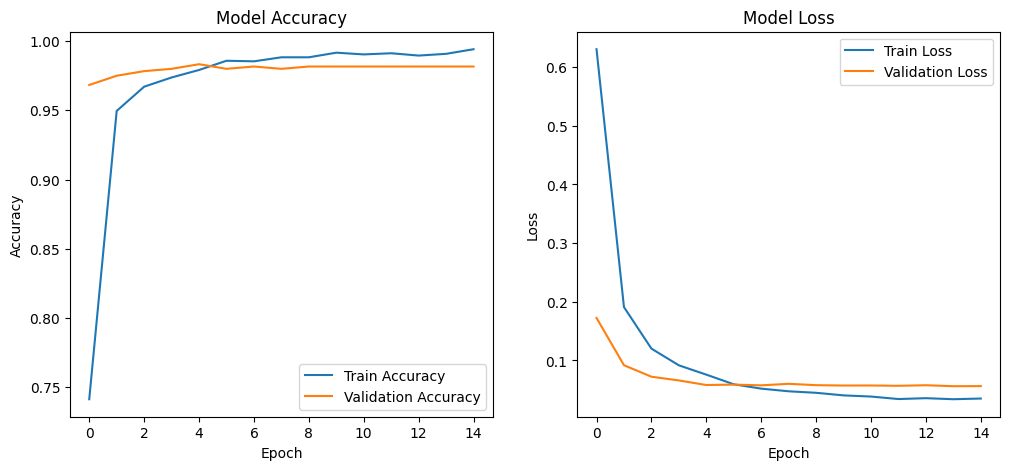

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 8. Evaluate the Model

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 370ms/step
              precision    recall  f1-score   support

        cats       0.99      0.96      0.98       200
        dogs       0.96      0.99      0.98       200
      snakes       0.99      0.98      0.99       200

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



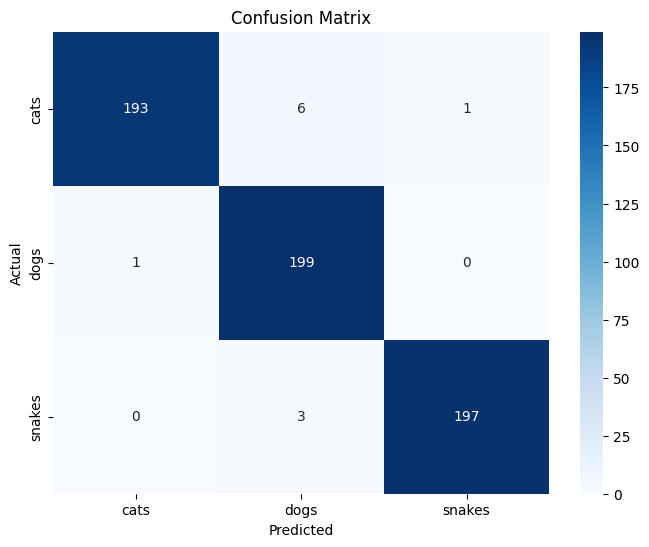

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
# 1. Get true labels and predictions from the validation generator
val_generator.reset()  # Reset generator to start from beginning
pred_probs = model.predict(val_generator, verbose=1) # Get predicted probabilities
pred_labels = np.argmax(pred_probs, axis=1) # Convert probabilities to class labels
true_labels = val_generator.classes # Get true labels from the generator

# 2. Get class names from the generator
class_names = list(val_generator.class_indices.keys())

# 3. Print classification report
print(classification_report(true_labels, pred_labels, target_names=class_names))

# 4. Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# 5. Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 9. Save the Model

In [14]:
# Save the entire model to a file
model.save('animal_classifier_model.h5')